# Analyze A/B Test Results 


- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)

<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.


<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

###  1.1
 read in the `ab_data.csv` data. Store it in `df`. 




**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head(5)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

**c.** The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

**d.** The proportion of users converted.

In [5]:
df['converted'].mean()

0.11965919355605512

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [6]:
#df.query("group == 'treatment' and landing_page == 'old_page'").count()
df.query("(landing_page == 'new_page' and group == 'control') or (landing_page == 'old_page' and group == 'treatment')").shape[0]

3893

**f.** Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

###  1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  


We need to figure out how should we handle the rows where the group and landing_page columns don't match?

**a.** Now create a new dataset.  Store new dataframe in **df2**.

In [8]:
# Remove the inaccurate rows, and store the result in a new dataframe df2

index1 =  df.query("group == 'treatment' and landing_page != 'new_page'").index
df1 = df.drop(index1)
index2 =  df.query("group == 'control' and landing_page != 'old_page'").index
df2 = df1.drop(index2)

In [9]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### T 1.3  


**a.** How many unique **user_id**s are in **df2**?

In [10]:
df2['user_id'].nunique()

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [11]:
duplicate_user = df2[df2.duplicated(subset=['user_id'])]
duplicate_user['user_id']

2893    773192
Name: user_id, dtype: int64

**c.** Display the rows for the duplicate **user_id**? 

In [12]:
duplicate_user

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [13]:

# Hint: The dataframe.drop_duplicates() may not work in this case because the rows with duplicate user_id are not entirely identical. 
df2.drop(duplicate_user.index)


df2.duplicated().sum()

0

###  1.4  

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>




In [14]:
ppop = df2['converted'].mean()
ppop

0.11959667567149027

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
pc = (df2.query("group == 'control'")['converted']==True).mean()
pc

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
pt=(df2.query("group == 'treatment'")['converted']==True).mean()
pt

0.11880724790277405

In [17]:

obs_diff = pc - pt
obs_diff

0.0015790565976871451

**d.** What is the probability that an individual received the new page?

In [18]:
(df2['landing_page']=='new_page').mean()

0.5000636646764286

**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

> taking in consideration the results from part (d) which indicates that treatment group will lead to more conversions since the probabilty of the control group is less than the treatment group and the probability of the population is 12%

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### ToDo 2.1
For now, consider you need to make the decision just based on all the data provided.  

> Recall that you just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page (ToDo 1.4.c). 

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

> $$h0: 𝑝𝑛𝑒𝑤 -   𝑝𝑜𝑙𝑑 <= 0$$
  $$h1: 𝑝𝑛𝑒𝑤 -   𝑝𝑜𝑙𝑑 > 0$$

### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, you will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 



Use the cells below to provide the necessary parts of this simulation.  You can use **Quiz 5** in the classroom to make sure you are on the right track.

**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [36]:
pnew = df2.converted
pnew = pnew.mean()
pnew

0.11959667567149027

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [37]:
pold = df2.converted
pold = pold.mean()
pold

0.11959667567149027

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>
*Hint*: The treatment group users are shown the new page.

In [34]:
nnew = df2.query("group == 'treatment'").user_id.nunique()
nnew 

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [22]:
nold = df2.query("group == 'control'").user_id.nunique()
nold

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>
*Hint*: Use `numpy.random.choice()` method to randomly generate $n_{new}$ number of values. <br>
Store these $n_{new}$ 1's and 0's in the `new_page_converted` numpy array.


In [23]:
# Simulate a Sample for the treatment Group
new_page_converted= np.random.choice(pnew, nnew, replace=True)
new_page_converted= np.array(new_page_converted)

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [24]:
# Simulate a Sample for the control Group
old_page_converted= np.random.choice(pold, nold, replace=True)
old_page_converted= np.array(old_page_converted)

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [25]:
p_new = new_page_converted.mean()
p_old = old_page_converted.mean()
p_diff = p_new-p_old
p_diff

-0.00068344986507462568


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [40]:
new_converted_simulation = np.random.binomial(nnew, pnew, 10000)/nnew
old_converted_simulation = np.random.binomial(nold, pold, 10000)/nold
p_diffs = new_converted_simulation - old_converted_simulation


**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.<br><br>

Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  



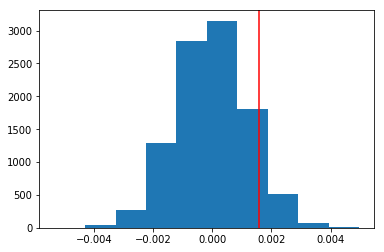

In [42]:
plt.hist(p_diffs)
plt.axvline(obs_diff, c='red');

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [44]:
(p_diffs > obs_diff).mean()

0.094500000000000001

**k.** Please explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies? 
  > its called the p-value 
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? *Hint*: Compare the value above with the "Type I error rate (0.05)".

> when the p-value is bigger than the type error 1 margin (0.05) it indicates that we fail to reject the null hypothesis



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [ ]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query("landing_page == 'old_page'").converted.sum()

# number of conversions with the new_page
convert_new =df2.query("landing_page == 'new_page'").converted.sum()

# number of individuals who were shown the old_page
n_old = df2.query("landing_page == 'old_page'").user_id.nunique()

# number of individuals who received new_page
n_new = df2.query("landing_page == 'new_page'").user_id.nunique()

**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 
>**Hint**: <br>
It's a two-tailed if you defined $H_1$ as $(p_{new} = p_{old})$. <br>
It's a left-tailed if you defined $H_1$ as $(p_{new} < p_{old})$. <br>
It's a right-tailed if you defined $H_1$ as $(p_{new} > p_{old})$. 

The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. We determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. In other words, a "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.

>Hint:<br>
For a right-tailed test, reject null if $Z_{score}$ > $Z_{\alpha}$. <br>
For a left-tailed test, reject null if $Z_{score}$ < $Z_{\alpha}$. 




Reference: 
- Example 9.1.2 on this [page](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.01%3A_Comparison_of_Two_Population_Means-_Large_Independent_Samples), courtesy www.stats.libretexts.org

---

>**Tip**: You don't have to dive deeper into z-test for this exercise. **Try having an overview of what does z-score signify in general.** 

In [ ]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest(count=(convert_old,convert_new), nobs=(n_old,n_new),alternative='larger')
print(z_score, p_value)

**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>



> since the z_score is smaller than the z0.05 value then we fail to reject the null hypothesis which agrees with our findings from parts j and k

<a id='regression'></a>
### Part III - A regression approach

### ToDo 3.1 
In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

> logistic regression

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [ ]:
dummies = pd.get_dummies(df2['group'])
df2 = df2.join(dummies)

In [ ]:
df2['intercept'] = 1

In [ ]:
df2 = df2.rename(columns={'treatment': 'ab_page'})

In [ ]:
df2 = df2.drop('control', axis=1)

**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [ ]:
log_mod = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
results = log_mod.fit()

**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [ ]:
results.summary2()

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  



> the p-value of ab_page is 0.1897 is very small, which suggests there is statistical evidence that the population slope associated with the group (treatment or control) in relating to conversion is non-zero. it probably differs from p value in part 2 cause this model doesnt fit well






**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

> i think if age groups was available it would've played a vital role in predicting our conversionn rate

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 


 Provide the statistical output as well as a written response to answer this question.

In [ ]:

countries = pd.read_csv('countries.csv')

In [ ]:

df_merged = df2.set_index('user_id').join(countries.set_index('user_id'))
df_merged.head(5)

In [ ]:

df_merged[['CA', 'UK', 'US' ]] = pd.get_dummies(df_merged['country'])
df_merged = df_merged.drop('CA', axis=1)
log_mod2 = sm.OLS(df_merged['converted'], df_merged[['intercept','ab_page','UK', 'US']])
results2 = log_mod2.fit()
results2.summary()

> p values for US and UK are very small which suggests that they are mor significant to our conversion rates

**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


Provide the summary results (statistical output), and your conclusions (written response) based on the results. 
